# Sentiment Classification with DistilBERT Embeddings and Logistic Regression

This notebook studies binary sentiment classification on Amazon reviews using
pretrained DistilBERT embeddings as fixed feature extractors, followed by a
linear classifier.

The objective is to evaluate different strategies for aggregating transformer
hidden states and assess how simple classifiers perform on top of powerful
language representations.

## Methodology
1. Load and clean Amazon review data.
2. Explore text length statistics.
3. Extract sentence embeddings using DistilBERT:
   - last hidden layer mean pooling
   - average of last N layers
   - weighted sum of last layers
4. Train a logistic regression classifier.
5. Select the best embedding strategy on validation data.
6. Evaluate on a held-out test set.

## Reproducibility
- Fixed random seeds are used throughout.
- DistilBERT is used in inference mode only (no fine-tuning).


In [1]:
import random
from functools import partial
import pandas as pd
import bz2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings("ignore")

In [2]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

## Load Pretrained DistilBERT
Model and tokenizer are loaded once and used only for embedding extraction.

In [3]:
%%capture
device = "cuda" if torch.cuda.is_available() else "cpu"
name = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(name, use_fast=True)
model = AutoModel.from_pretrained(name).to(device)
model.eval()

## Data Loading and Preprocessing

We use the Amazon Reviews dataset provided in FastText format.
Labels are mapped to binary sentiment:
- 0 → negative
- 1 → positive

Each review is lowercased and stripped of punctuation.


In [4]:
def unzip_files(filepath):
    """
    Args:
        filepath: the file to unzip
    Returns:
        labels: List with the labels of each review
        texts:  List with the text of each review
    """
    labels, texts = [], []
    with bz2.open(filepath, 'rt') as file:
        for line in file:
            line = line.strip()
            label, text = line.split(" ", 1)
            label = label.replace("__label__", "")
            labels.append(label)
            texts.append(text)

    return labels, texts

def clean_text(text):
    """
    Expects a Series.
    """
    text = text.str.lower()

    # remove punctuation and hyphens
    text = text.str.replace(r'[^\w\s]', '', regex=True)

    return text

def make_dataframe(labels, texts):
    df = pd.DataFrame({"label": labels, "text": texts})
    df['label'] = df['label'].astype(int)
    df['label'] = df['label'].map({1: 0, 2: 1})
    df['text'] = clean_text(df['text'])
    
    return df

In [5]:
labels, texts = unzip_files("/kaggle/input/amazonreviews/train.ft.txt.bz2")
train_df = make_dataframe(labels, texts)

labels, texts = unzip_files("/kaggle/input/amazonreviews/test.ft.txt.bz2")
test_df = make_dataframe(labels, texts)

In [6]:
train_df.head()

,label,text
0,1,stuning even for the nongamer this sound track...
1,1,the best soundtrack ever to anything im readin...
2,1,amazing this soundtrack is my favorite music o...
3,1,excellent soundtrack i truly like this soundtr...
4,1,remember pull your jaw off the floor after hea...


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3600000 entries, 0 to 3599999
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   label   int64 
 1   text    object
dtypes: int64(1), object(1)
memory usage: 54.9+ MB


In [8]:
train_df['label'].value_counts()

label
1    1800000
0    1800000
Name: count, dtype: int64

In [9]:
train_df['word count'] = train_df['text'].apply(lambda text: len(text.split()))

print("Descriptive statistics for number of words in each review:")
print(train_df['word count'].describe())

print("\nAverage number of words per category")
print(train_df.groupby('label')['word count'].describe())

Descriptive statistics for number of words in each review:
count    3.600000e+06
mean     7.818634e+01
std      4.269052e+01
min      0.000000e+00
25%      4.200000e+01
50%      7.000000e+01
75%      1.080000e+02
max      2.570000e+02
Name: word count, dtype: float64

Average number of words per category
           count       mean        std  min   25%   50%    75%    max
label                                                                
0      1800000.0  81.193271  42.430791  1.0  46.0  74.0  111.0  257.0
1      1800000.0  75.179400  42.737653  0.0  39.0  66.0  104.0  222.0


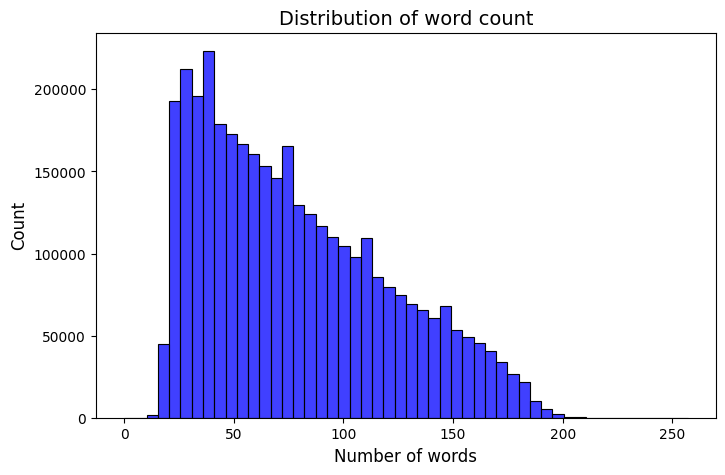

In [10]:
plt.figure(figsize=(8,5))
sns.histplot(train_df['word count'], bins=50, color='blue')
plt.title("Distribution of word count", fontsize=14)
plt.xlabel("Number of words", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()

Due to computational constraints, we subsample 50k training examples.
This is sufficient to compare embedding strategies while keeping runtime reasonable.


In [11]:
X = train_df['text']
y = train_df['label']

# Subsample for computational efficiency
MAX_TRAIN = 50_000
X = X.iloc[:MAX_TRAIN]
y = y.iloc[:MAX_TRAIN]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=SEED, stratify=y, shuffle=True)

In [12]:
np.sum(y_train == 1) / y_train.shape[0]

0.5101142857142857

## Baseline: TF-IDF + Logistic Regression

As a classical NLP baseline, we train a logistic regression classifier on
TF-IDF features. This provides a non-neural benchmark and helps
quantify the benefit of transformer-based embeddings.

In [13]:
tfidf = TfidfVectorizer(
    max_features=50_000,
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.9,
    stop_words="english"
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)

tfidf_clf = LogisticRegression(max_iter=1000, n_jobs=-1, random_state=SEED)
tfidf_clf.fit(X_train_tfidf, y_train)

val_preds_tfidf = tfidf_clf.predict(X_val_tfidf)
acc_tfidf = accuracy_score(y_val, val_preds_tfidf)

print(f"TF-IDF + Logistic Regression validation accuracy: {acc_tfidf:.4f}")

TF-IDF + Logistic Regression validation accuracy: 0.8789


In [14]:
def _mean_pool(hidden, attention_mask):
    # hidden: # [batch_size, max_length, hidden_size]
    # attention_mask: # [batch_size, max_length]
    mask = attention_mask.unsqueeze(-1)      # [batch_size, max_length, 1]
    summed = (hidden * mask).sum(dim=1)      # [batch_size, hidden_size]
    counts = mask.sum(dim=1).clamp(min=1)    # [batch_size, 1]
    pooled = (summed / counts).cpu().numpy() # [batch_size, hidden_size]
    return pooled

def embedding_last_layer(X, batch_size=256, max_length=128):
    """
    Extract sentence embeddings by mean pooling the last hidden layer
    of DistilBERT.

    Args:
        X: pd.Series of texts
    Returns:
        np.ndarray of shape (n_samples, hidden_size)
    """
    embeddings = []
    
    with torch.no_grad():
        for i in range(0, len(X), batch_size):
            batch = X[i: i+batch_size].values.tolist()
            tokens = tokenizer(batch, padding=True, truncation=True, max_length=max_length, return_tensors="pt")
            tokens = {key: value.to(device) for key, value in tokens.items()}
            hidden = model(**tokens).last_hidden_state # [batch_size, max_length, hidden_size]
            attention_mask = tokens['attention_mask']  # [batch_size, max_length]
            pooled = _mean_pool(hidden, attention_mask)
            
            embeddings.append(pooled)

    return np.vstack(embeddings)

def embedding_average_last_N(X, batch_size=256, max_length=128, N=4):
    """
    Extract sentence embeddings by mean pooling the last N layers
    of DistilBERT.

    Args:
        X: pd.Series of texts
    Returns:
        np.ndarray of shape (n_samples, hidden_size)
    """
    embeddings = []
    
    with torch.no_grad():
        for i in range(0, len(X), batch_size):
            batch = X[i: i+batch_size].values.tolist()
            tokens = tokenizer(batch, padding=True, truncation=True, max_length=max_length, return_tensors="pt")
            tokens = {key: value.to(device) for key, value in tokens.items()}
            embedding = model(**tokens, output_hidden_states=True).hidden_states[-N:] # Last N, each [batch_size, max_length, hidden_size]
            stacked = torch.stack(embedding, dim=0) # [N, batch_size, max_length, hidden_size]
            average = stacked.mean(dim=0)           # [batch_size, max_length, hidden_size]
            attention_mask = tokens['attention_mask'] # [batch_size, max_length]
            pooled = _mean_pool(average, attention_mask)
            
            embeddings.append(pooled)

    return np.vstack(embeddings)

def embedding_weighted_sum(X, weights=[0.1, 0.2, 0.3, 0.4], batch_size=256, max_length=128):
    """
    Extract sentence embeddings by weight pooling of the last four layers
    of DistilBERT.

    Args:
        X: pd.Series of texts
    Returns:
        np.ndarray of shape (n_samples, hidden_size)
    """
    size = len(weights)
    weights = torch.tensor(weights).to(device)
    embeddings = []

    with torch.no_grad():
        for i in range(0, len(X), batch_size):
            batch = X[i: i+batch_size].values.tolist()
            tokens = tokenizer(batch, padding=True, truncation=True, max_length=max_length, return_tensors="pt")
            tokens = {key: value.to(device) for key, value in tokens.items()}
            embedding = model(**tokens, output_hidden_states=True).hidden_states[-size:] # last size layers, each [batch_size, max_length, hidden_size]
            stacked = torch.stack(embedding, dim=0) # [K, batch_size, max_length, hidden_size]
            weighted_embedding = (weights.view(-1, 1, 1, 1)*stacked).sum(dim=0) # [batch_size, max_length, hidden_size]
            attention_mask = tokens['attention_mask'] # [batch_size, max_length]
            pooled = _mean_pool(weighted_embedding, attention_mask)
            
            embeddings.append(pooled)
    
    return np.vstack(embeddings)

## Last Layer Embedding

In [15]:
best_model = {
    "accuracy": -np.inf,
    "scaler": None,
    "classifier": None,
    "best_embedding": None
}
train_embeddings = embedding_last_layer(X_train)
scaler = StandardScaler()
train_embeddings = scaler.fit_transform(train_embeddings)

clf = LogisticRegression(max_iter=1000)
clf.fit(train_embeddings, y_train)

val_embeddings = embedding_last_layer(X_val)
val_embeddings = scaler.transform(val_embeddings)
predictions = clf.predict(val_embeddings)

accuracy = accuracy_score(y_val, predictions)
acc_last = accuracy
print(f"Accuracy: ", accuracy)

if accuracy > best_model['accuracy']:
    best_model['accuracy'] = accuracy
    best_model['scaler'] = scaler
    best_model['classifier'] = clf
    best_model['best_embedding'] = partial(embedding_last_layer)

Accuracy:  0.8824666666666666


## Last N Layers

In [16]:
train_embeddings = embedding_average_last_N(X_train)
scaler = StandardScaler()
train_embeddings = scaler.fit_transform(train_embeddings)

clf = LogisticRegression(max_iter=1000)
clf.fit(train_embeddings, y_train)

val_embeddings = embedding_average_last_N(X_val)
val_embeddings = scaler.transform(val_embeddings)
predictions = clf.predict(val_embeddings)

accuracy = accuracy_score(y_val, predictions)
acc_avg = accuracy
print(f"Accuracy: ", accuracy)

if accuracy > best_model['accuracy']:
    best_model['accuracy'] = accuracy
    best_model['scaler'] = scaler
    best_model['classifier'] = clf
    best_model['best_embedding'] = partial(embedding_average_last_N)

Accuracy:  0.8784666666666666


## Weighted Sum

In [17]:
train_embeddings = embedding_weighted_sum(X_train)
scaler = StandardScaler()
train_embeddings = scaler.fit_transform(train_embeddings)

clf = LogisticRegression(max_iter=1000)
clf.fit(train_embeddings, y_train)

val_embeddings = embedding_weighted_sum(X_val)
val_embeddings = scaler.transform(val_embeddings)
predictions = clf.predict(val_embeddings)

accuracy = accuracy_score(y_val, predictions)
acc_weighted = accuracy
print(f"Accuracy: ", accuracy)

if accuracy > best_model['accuracy']:
    best_model['accuracy'] = accuracy
    best_model['scaler'] = scaler
    best_model['classifier'] = clf
    best_model['best_embedding'] = partial(embedding_weighted_sum)

Accuracy:  0.8812666666666666


In [18]:
clf = best_model['classifier']
scaler = best_model['scaler']
embedding_func = best_model['best_embedding']


# Limit test size for faster iteration
MAX_TEST = 10_000
test_df = test_df.iloc[:MAX_TEST]
X_test = test_df['text']
y_test = test_df['label']

test_embeddings = embedding_func(X_test)

test_embeddings = scaler.transform(test_embeddings)
predictions = clf.predict(test_embeddings)

accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: ", accuracy)

print("\nClassification Report:")
print(classification_report(y_test, predictions))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, predictions))

Accuracy:  0.8787

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.88      0.88      4875
           1       0.88      0.88      0.88      5125

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000


Confusion Matrix:
[[4282  593]
 [ 620 4505]]


In [19]:
comparison_df = pd.DataFrame([
    {"Model": "TF-IDF + Logistic Regression", "Val Accuracy": acc_tfidf},
    {"Model": "DistilBERT Last Layer (mean)", "Val Accuracy": acc_last},
    {"Model": "DistilBERT Avg Last N Layers", "Val Accuracy": acc_avg},
    {"Model": "DistilBERT Weighted Sum", "Val Accuracy": acc_weighted},
]).sort_values("Val Accuracy", ascending=False).set_index("Model")

comparison_df


,Val Accuracy
Model,
DistilBERT Last Layer (mean),0.882467
DistilBERT Weighted Sum,0.881267
TF-IDF + Logistic Regression,0.878867
DistilBERT Avg Last N Layers,0.878467


## Validation Results

The table above compares a classical TF-IDF baseline against several
DistilBERT embedding strategies.

Key observations:
- DistilBERT with mean pooling over the last hidden layer achieves the
  highest validation accuracy.
- A weighted sum of the last layers performs comparably, but without a
  clear advantage.
- The TF-IDF baseline remains highly competitive, highlighting that
  traditional methods are strong for sentiment classification tasks.